In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Ntrain = train_input_100.size(0)
Ntest = test_input_100.size(0)
Nchannels = train_input_100.size(1)
Nsamples_100 = train_input_100.size(-1)
Nsamples_1000 = train_input_1000.size(-1)

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

In [3]:
class conv2DNet(nn.Module):
    
    def __init__(self, Nchannels, Nsamples, output_units):
        """Initializes neural network with 3 convolutional layers and 1 fully-connected layer.
        
        Args:
            - Nchannels (int): number of EEG channels
            - Nsamples (int): number of time points in each EEG signal
            - output_units (int): number of output units, e.g. 1 for training with loss torch.nn.BCELoss or 2 with 
            loss torch.nn.CrossEntropyLoss            
            
            """
        super(conv2DNet, self).__init__()
        # Layer 1
        l1_channels = 16  
        self.conv1 = nn.Conv2d(1, l1_channels, (Nchannels, 1), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(l1_channels, False) # final size bsize x 1 x l1_channels x Nsamples

        # Layer 2
        l2_channels = 4
        l2_temp_window = 32
        l2_l1channel_overlap = 2
        self.padding1 = nn.ZeroPad2d((l2_temp_window // 2, l2_temp_window // 2 - 1, l2_l1channel_overlap//2-1, l2_l1channel_overlap//2)) # left, right, top, bottom
        self.conv2 = nn.Conv2d(1, l2_channels, (l2_l1channel_overlap, l2_temp_window))  # does not change size if combined with above padding
        self.batchnorm2 = nn.BatchNorm2d(l2_channels, False)
        self.pooling2 = nn.MaxPool2d((2, 4)) # final size bsize x l2_channels x floor(l1_channels/2) x floor(Nsamples/4)

        # Layer 3
        l3_channels = 4
        l3_temp_window = 4
        l3_l2channel_overlap = 8
        self.padding2 = nn.ZeroPad2d((l3_temp_window//2, l3_temp_window//2-1, l3_l2channel_overlap//2, l3_l2channel_overlap//2-1))
        self.conv3 = nn.Conv2d(l2_channels, l3_channels, (l3_l2channel_overlap, l3_temp_window))
        self.batchnorm3 = nn.BatchNorm2d(l3_channels, False)
        self.pooling3 = nn.MaxPool2d((2, 4)) # final size bsize x l3_channels x floor(l1_channels/4) x floor(Nsamples/16)

        # FC Layer
        fc_inputs = l3_channels * (l1_channels//4) * (Nsamples//16)
        self.fc1 = nn.Linear(fc_inputs, output_units)
        
        
    def forward(self, x):
        """Applies forward pass consisting of 3 convolutional layers followed by a fully-connected linear layer.
        
        Args:
            - x (torch.autograd.Variable): the input batch. It has dimension batch_size x Nchannel x Nsamples x 1,
            where Nchannel is the number of EEG channels and Nsamples the number of time points.
        
        Returns:
            - (torch.autograd.Variable) of size either batch_size x output_units   
        
        """
        x = x.permute(0, 3, 1, 2)             # bsize x 1 x Nchannels x Nsamples
        
        # Layer 1
        x = F.relu(self.conv1(x))              # bsize x l1_channels x 1 x Nsamples
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.3)
        x = x.permute(0, 2, 1, 3)             # bsize x 1 x l1_channels x Nsamples

        # Layer 2
        x = self.padding1(x)
        x = F.relu(self.conv2(x))              # bsize x l2_channels x l1_channels x Nsamples
        x = self.batchnorm2(x)       
        x = F.dropout(x, 0.3)
        x = self.pooling2(x)                  # bsize x l2_channels x floor(l1_channels/2) x floor(Nsamples/4)

        # Layer 3
        x = self.padding2(x)
        x = F.relu(self.conv3(x))              # bsize x l3_channels x floor(l1_channels/2) x floor(Nsamples/4)
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.3)
        x = self.pooling3(x)                  # bsize x l3_channels x floor(l1_channels/4) x floor(Nsamples/16)

        # Fully-connected Layer
        x = x.view(-1, self.fc1.in_features)  # bsize x (l3_channels*floor(l1_channels/4)*floor(Nsamples/16))
        x = F.sigmoid(self.fc1(x))            # bisze x self.fc1.out_features  
        
        if self.fc1.out_features == 1:
            x = x.view(-1)                     # bsize (1D if 1 output unit)
        
        return x

In [4]:
def compute_nb_errors(model, data_input, data_target):
    batch_size = 25  # not as crucial as in training. Just a matter of memory.
    nb_errors = 0
    Ndata = data_input.size(0)
    model.eval()
    
    for b_start in range(0, data_input.size(0), batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np
from utility import * 

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target = preprocessing_train(train_input_1000, train_target_1000, False, False)
preprocessed_input_test = preprocessing_test(test_input_100, False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = test_target_100
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

preprocessed_input_train_target = torch.from_numpy(preprocessed_input_train_target)
preprocessed_input_validation_target = torch.from_numpy(preprocessed_input_validation_target)

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

print('Ntrain', Ntrain)
print('Ntest', Ntest)
print('Nvalidation', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, Nchannels, Nsamples_100, 1))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, Nchannels, Nsamples_100, 1), volatile=True )
test_input = Variable(preprocessed_input_test.view(Ntest, Nchannels, Nsamples_100, 1), volatile=True )

train (2701, 28, 50)
test (100, 28, 50)
validation (144, 28, 50)
Ntrain 2701
Ntest 100
Nvalidation 144


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(preprocessed_input_train_target)  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True) # convert to float
    test_target = Variable(test_target_100, volatile=True )
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(preprocessed_input_train_target)  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True) # convert to float
    test_target = Variable(test_target_100, volatile=True )
    Noutputs = 2
    
else:
    train_target = Variable(preprocessed_input_train_target.float()) # convert to float
    validation_target = Variable(preprocessed_input_validation_target.float(), volatile=True ) # convert to float
    test_target = Variable(test_target_100.float(), volatile=True )
    Noutputs = 1
        
model = conv2DNet(Nchannels, Nsamples_100, Noutputs)

#optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.90, nesterov=False)
#optimizer = optim.Adam(model.parameters())
#optimizer = optim.Adagrad(model.parameters())
#optimizer = optim.Adamax(model.parameters())
#optimizer = optim.ASGD(model.parameters())
#optimizer = optim.RMSprop(model.parameters())
optimizer = optim.Rprop(model.parameters())
#optimizer = optim.Adamax(model.parameters())
#optimizer = optim.Adamax(model.parameters())
#optimizer = optim.Adamax(model.parameters())

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

batch_size = 25
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 1500
Nrep = 1

train_errors = torch.Tensor(Nepochs).zero_()
test_errors = torch.Tensor(Nepochs).zero_()
validation_errors = torch.Tensor(Nepochs).zero_()

ep_loss = torch.Tensor(Nepochs).zero_()

for i_rep in range(Nrep):
    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_ep])
        nb_train_errs = compute_nb_errors(model, train_input, train_target)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target)
        # Evaluate on test data
        nb_test_errs = compute_nb_errors(model, test_input, test_target)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) #!!!!!!!!!!!!!!!!
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_ep])
        
        train_errors[i_ep] = nb_train_errs
        test_errors[i_ep] = nb_test_errs
        validation_errors[i_ep] = nb_validation_errs

Epoch Number :  0
	 Training accuracy:  58.83006293965198
	 Validation accuracy  61.111111111111114
	 Test accuracy  50.0
	 Epoch Loss  73.16120147705078
Epoch Number :  1
	 Training accuracy:  58.607922991484635
	 Validation accuracy  60.416666666666664
	 Test accuracy  50.0
	 Epoch Loss  72.38387298583984
Epoch Number :  2
	 Training accuracy:  58.718992965568304
	 Validation accuracy  61.111111111111114
	 Test accuracy  50.0
	 Epoch Loss  72.36580657958984
Epoch Number :  3
	 Training accuracy:  58.79303961495742
	 Validation accuracy  61.111111111111114
	 Test accuracy  50.0
	 Epoch Loss  72.35186004638672
Epoch Number :  4
	 Training accuracy:  58.83006293965198
	 Validation accuracy  61.111111111111114
	 Test accuracy  50.0
	 Epoch Loss  72.33895111083984
Epoch Number :  5
	 Training accuracy:  58.9041095890411
	 Validation accuracy  61.111111111111114
	 Test accuracy  49.0
	 Epoch Loss  72.32614135742188
Epoch Number :  6
	 Training accuracy:  58.9041095890411
	 Validation accur

Epoch Number :  55
	 Training accuracy:  60.60718252499075
	 Validation accuracy  64.58333333333333
	 Test accuracy  51.0
	 Epoch Loss  71.66910552978516
Epoch Number :  56
	 Training accuracy:  60.755275823768976
	 Validation accuracy  65.27777777777777
	 Test accuracy  51.0
	 Epoch Loss  71.65619659423828
Epoch Number :  57
	 Training accuracy:  60.755275823768976
	 Validation accuracy  65.27777777777777
	 Test accuracy  51.0
	 Epoch Loss  71.64313507080078
Epoch Number :  58
	 Training accuracy:  60.866345797852645
	 Validation accuracy  65.27777777777777
	 Test accuracy  51.0
	 Epoch Loss  71.62989807128906
Epoch Number :  59
	 Training accuracy:  60.866345797852645
	 Validation accuracy  65.27777777777777
	 Test accuracy  51.0
	 Epoch Loss  71.61681365966797
Epoch Number :  60
	 Training accuracy:  60.792299148463535
	 Validation accuracy  65.27777777777777
	 Test accuracy  51.0
	 Epoch Loss  71.60384368896484
Epoch Number :  61
	 Training accuracy:  60.94039244724176
	 Validation

Epoch Number :  109
	 Training accuracy:  62.93965198074787
	 Validation accuracy  64.58333333333333
	 Test accuracy  54.0
	 Epoch Loss  70.8772201538086
Epoch Number :  110
	 Training accuracy:  62.97667530544243
	 Validation accuracy  64.58333333333333
	 Test accuracy  54.0
	 Epoch Loss  70.85963439941406
Epoch Number :  111
	 Training accuracy:  63.087745279526104
	 Validation accuracy  64.58333333333333
	 Test accuracy  53.0
	 Epoch Loss  70.84207153320312
Epoch Number :  112
	 Training accuracy:  63.12476860422066
	 Validation accuracy  64.58333333333333
	 Test accuracy  53.0
	 Epoch Loss  70.82391357421875
Epoch Number :  113
	 Training accuracy:  63.12476860422066
	 Validation accuracy  64.58333333333333
	 Test accuracy  53.0
	 Epoch Loss  70.80592346191406
Epoch Number :  114
	 Training accuracy:  63.087745279526104
	 Validation accuracy  64.58333333333333
	 Test accuracy  53.0
	 Epoch Loss  70.78800201416016
Epoch Number :  115
	 Training accuracy:  63.050721954831545
	 Valida

Epoch Number :  163
	 Training accuracy:  62.90262865605332
	 Validation accuracy  63.19444444444444
	 Test accuracy  54.0
	 Epoch Loss  69.5793685913086
Epoch Number :  164
	 Training accuracy:  62.90262865605332
	 Validation accuracy  63.19444444444444
	 Test accuracy  55.0
	 Epoch Loss  69.55809783935547
Epoch Number :  165
	 Training accuracy:  62.97667530544243
	 Validation accuracy  63.888888888888886
	 Test accuracy  55.0
	 Epoch Loss  69.53594207763672
Epoch Number :  166
	 Training accuracy:  63.087745279526104
	 Validation accuracy  63.888888888888886
	 Test accuracy  55.0
	 Epoch Loss  69.51118469238281
Epoch Number :  167
	 Training accuracy:  63.12476860422066
	 Validation accuracy  63.888888888888886
	 Test accuracy  55.0
	 Epoch Loss  69.47699737548828
Epoch Number :  168
	 Training accuracy:  63.19881525360977
	 Validation accuracy  63.19444444444444
	 Test accuracy  54.0
	 Epoch Loss  69.42431640625
Epoch Number :  169
	 Training accuracy:  63.27286190299889
	 Validati

Epoch Number :  216
	 Training accuracy:  63.90225842280637
	 Validation accuracy  64.58333333333333
	 Test accuracy  59.0
	 Epoch Loss  68.36994934082031
Epoch Number :  217
	 Training accuracy:  63.90225842280637
	 Validation accuracy  64.58333333333333
	 Test accuracy  59.0
	 Epoch Loss  68.34732055664062
Epoch Number :  218
	 Training accuracy:  63.97630507219548
	 Validation accuracy  64.58333333333333
	 Test accuracy  59.0
	 Epoch Loss  68.32415771484375
Epoch Number :  219
	 Training accuracy:  63.93928174750093
	 Validation accuracy  64.58333333333333
	 Test accuracy  59.0
	 Epoch Loss  68.30140686035156
Epoch Number :  220
	 Training accuracy:  63.97630507219548
	 Validation accuracy  64.58333333333333
	 Test accuracy  59.0
	 Epoch Loss  68.27874755859375
Epoch Number :  221
	 Training accuracy:  63.97630507219548
	 Validation accuracy  64.58333333333333
	 Test accuracy  59.0
	 Epoch Loss  68.25650024414062
Epoch Number :  222
	 Training accuracy:  63.93928174750093
	 Validati

Epoch Number :  269
	 Training accuracy:  65.272121436505
	 Validation accuracy  68.05555555555556
	 Test accuracy  57.0
	 Epoch Loss  67.19215393066406
Epoch Number :  270
	 Training accuracy:  65.19807478711589
	 Validation accuracy  68.05555555555556
	 Test accuracy  57.0
	 Epoch Loss  67.16923522949219
Epoch Number :  271
	 Training accuracy:  65.23509811181044
	 Validation accuracy  68.05555555555556
	 Test accuracy  57.0
	 Epoch Loss  67.14579772949219
Epoch Number :  272
	 Training accuracy:  65.23509811181044
	 Validation accuracy  68.05555555555556
	 Test accuracy  57.0
	 Epoch Loss  67.12216186523438
Epoch Number :  273
	 Training accuracy:  65.30914476119956
	 Validation accuracy  68.05555555555556
	 Test accuracy  57.0
	 Epoch Loss  67.09893035888672
Epoch Number :  274
	 Training accuracy:  65.38319141058867
	 Validation accuracy  68.05555555555556
	 Test accuracy  57.0
	 Epoch Loss  67.07564544677734
Epoch Number :  275
	 Training accuracy:  65.38319141058867
	 Validation

Epoch Number :  325
	 Training accuracy:  66.79007774898186
	 Validation accuracy  68.75
	 Test accuracy  57.0
	 Epoch Loss  65.90216827392578
Epoch Number :  326
	 Training accuracy:  66.82710107367642
	 Validation accuracy  69.44444444444444
	 Test accuracy  57.0
	 Epoch Loss  65.87828826904297
Epoch Number :  327
	 Training accuracy:  66.90114772306553
	 Validation accuracy  69.44444444444444
	 Test accuracy  57.0
	 Epoch Loss  65.85429382324219
Epoch Number :  328
	 Training accuracy:  66.9381710477601
	 Validation accuracy  69.44444444444444
	 Test accuracy  57.0
	 Epoch Loss  65.82968139648438
Epoch Number :  329
	 Training accuracy:  66.9381710477601
	 Validation accuracy  69.44444444444444
	 Test accuracy  57.0
	 Epoch Loss  65.80561828613281
Epoch Number :  330
	 Training accuracy:  66.97519437245465
	 Validation accuracy  69.44444444444444
	 Test accuracy  57.0
	 Epoch Loss  65.78178405761719
Epoch Number :  331
	 Training accuracy:  67.04924102184376
	 Validation accuracy  6

Epoch Number :  379
	 Training accuracy:  68.41910403554239
	 Validation accuracy  70.13888888888889
	 Test accuracy  56.0
	 Epoch Loss  64.46903991699219
Epoch Number :  380
	 Training accuracy:  68.45612736023695
	 Validation accuracy  70.13888888888889
	 Test accuracy  56.0
	 Epoch Loss  64.43325805664062
Epoch Number :  381
	 Training accuracy:  68.34505738615327
	 Validation accuracy  70.13888888888889
	 Test accuracy  56.0
	 Epoch Loss  64.39602661132812
Epoch Number :  382
	 Training accuracy:  68.53017400962607
	 Validation accuracy  70.13888888888889
	 Test accuracy  56.0
	 Epoch Loss  64.34068298339844
Epoch Number :  383
	 Training accuracy:  68.64124398370974
	 Validation accuracy  70.13888888888889
	 Test accuracy  56.0
	 Epoch Loss  64.2857437133789
Epoch Number :  384
	 Training accuracy:  68.64124398370974
	 Validation accuracy  70.13888888888889
	 Test accuracy  56.0
	 Epoch Loss  64.24951171875
Epoch Number :  385
	 Training accuracy:  68.64124398370974
	 Validation a

Epoch Number :  433
	 Training accuracy:  71.71417993335801
	 Validation accuracy  75.69444444444444
	 Test accuracy  57.0
	 Epoch Loss  62.15598678588867
Epoch Number :  434
	 Training accuracy:  71.78822658274713
	 Validation accuracy  75.69444444444444
	 Test accuracy  57.0
	 Epoch Loss  62.11366653442383
Epoch Number :  435
	 Training accuracy:  71.86227323213625
	 Validation accuracy  75.69444444444444
	 Test accuracy  57.0
	 Epoch Loss  62.076637268066406
Epoch Number :  436
	 Training accuracy:  71.82524990744169
	 Validation accuracy  75.69444444444444
	 Test accuracy  57.0
	 Epoch Loss  62.024497985839844
Epoch Number :  437
	 Training accuracy:  71.8992965568308
	 Validation accuracy  75.69444444444444
	 Test accuracy  57.0
	 Epoch Loss  61.98257827758789
Epoch Number :  438
	 Training accuracy:  72.01036653091448
	 Validation accuracy  74.30555555555556
	 Test accuracy  57.0
	 Epoch Loss  61.91802978515625
Epoch Number :  439
	 Training accuracy:  71.1218067382451
	 Validati

Epoch Number :  486
	 Training accuracy:  72.52869307663828
	 Validation accuracy  73.61111111111111
	 Test accuracy  63.0
	 Epoch Loss  57.474449157714844
Epoch Number :  487
	 Training accuracy:  72.52869307663828
	 Validation accuracy  73.61111111111111
	 Test accuracy  63.0
	 Epoch Loss  57.43450164794922
Epoch Number :  488
	 Training accuracy:  72.52869307663828
	 Validation accuracy  73.61111111111111
	 Test accuracy  63.0
	 Epoch Loss  57.39436340332031
Epoch Number :  489
	 Training accuracy:  72.52869307663828
	 Validation accuracy  73.61111111111111
	 Test accuracy  63.0
	 Epoch Loss  57.35417938232422
Epoch Number :  490
	 Training accuracy:  72.52869307663828
	 Validation accuracy  73.61111111111111
	 Test accuracy  63.0
	 Epoch Loss  57.31431198120117
Epoch Number :  491
	 Training accuracy:  72.6027397260274
	 Validation accuracy  73.61111111111111
	 Test accuracy  63.0
	 Epoch Loss  57.274471282958984
Epoch Number :  492
	 Training accuracy:  72.67678637541651
	 Validat

Epoch Number :  539
	 Training accuracy:  74.19474268789337
	 Validation accuracy  75.69444444444444
	 Test accuracy  64.0
	 Epoch Loss  55.39506912231445
Epoch Number :  540
	 Training accuracy:  74.23176601258793
	 Validation accuracy  75.69444444444444
	 Test accuracy  64.0
	 Epoch Loss  55.357017517089844
Epoch Number :  541
	 Training accuracy:  74.23176601258793
	 Validation accuracy  75.69444444444444
	 Test accuracy  64.0
	 Epoch Loss  55.318572998046875
Epoch Number :  542
	 Training accuracy:  74.23176601258793
	 Validation accuracy  75.69444444444444
	 Test accuracy  64.0
	 Epoch Loss  55.27336502075195
Epoch Number :  543
	 Training accuracy:  74.23176601258793
	 Validation accuracy  75.69444444444444
	 Test accuracy  64.0
	 Epoch Loss  55.228721618652344
Epoch Number :  544
	 Training accuracy:  74.23176601258793
	 Validation accuracy  75.69444444444444
	 Test accuracy  64.0
	 Epoch Loss  55.184608459472656
Epoch Number :  545
	 Training accuracy:  74.3428359866716
	 Valid

Epoch Number :  592
	 Training accuracy:  75.67567567567568
	 Validation accuracy  75.69444444444444
	 Test accuracy  61.0
	 Epoch Loss  53.2857666015625
Epoch Number :  593
	 Training accuracy:  75.71269900037024
	 Validation accuracy  75.69444444444444
	 Test accuracy  61.0
	 Epoch Loss  53.304630279541016
Epoch Number :  594
	 Training accuracy:  75.71269900037024
	 Validation accuracy  75.69444444444444
	 Test accuracy  61.0
	 Epoch Loss  53.219058990478516
Epoch Number :  595
	 Training accuracy:  75.71269900037024
	 Validation accuracy  75.69444444444444
	 Test accuracy  61.0
	 Epoch Loss  53.1806755065918
Epoch Number :  596
	 Training accuracy:  75.71269900037024
	 Validation accuracy  75.69444444444444
	 Test accuracy  61.0
	 Epoch Loss  53.14579772949219
Epoch Number :  597
	 Training accuracy:  75.71269900037024
	 Validation accuracy  75.69444444444444
	 Test accuracy  61.0
	 Epoch Loss  53.114036560058594
Epoch Number :  598
	 Training accuracy:  75.7497223250648
	 Validati

Epoch Number :  646
	 Training accuracy:  76.49018881895594
	 Validation accuracy  75.69444444444444
	 Test accuracy  59.0
	 Epoch Loss  51.559452056884766
Epoch Number :  647
	 Training accuracy:  76.5272121436505
	 Validation accuracy  75.69444444444444
	 Test accuracy  59.0
	 Epoch Loss  51.52764129638672
Epoch Number :  648
	 Training accuracy:  76.5272121436505
	 Validation accuracy  75.69444444444444
	 Test accuracy  59.0
	 Epoch Loss  51.496337890625
Epoch Number :  649
	 Training accuracy:  76.63828211773418
	 Validation accuracy  75.69444444444444
	 Test accuracy  59.0
	 Epoch Loss  51.464637756347656
Epoch Number :  650
	 Training accuracy:  76.63828211773418
	 Validation accuracy  75.69444444444444
	 Test accuracy  59.0
	 Epoch Loss  51.43301773071289
Epoch Number :  651
	 Training accuracy:  76.63828211773418
	 Validation accuracy  75.69444444444444
	 Test accuracy  59.0
	 Epoch Loss  51.39763259887695
Epoch Number :  652
	 Training accuracy:  76.74935209181784
	 Validation

Epoch Number :  699
	 Training accuracy:  77.30470196223621
	 Validation accuracy  76.38888888888889
	 Test accuracy  60.0
	 Epoch Loss  49.98740768432617
Epoch Number :  700
	 Training accuracy:  77.30470196223621
	 Validation accuracy  76.38888888888889
	 Test accuracy  60.0
	 Epoch Loss  49.958961486816406
Epoch Number :  701
	 Training accuracy:  77.23065531284709
	 Validation accuracy  76.38888888888889
	 Test accuracy  60.0
	 Epoch Loss  49.930789947509766
Epoch Number :  702
	 Training accuracy:  77.26767863754165
	 Validation accuracy  76.38888888888889
	 Test accuracy  60.0
	 Epoch Loss  49.903499603271484
Epoch Number :  703
	 Training accuracy:  77.30470196223621
	 Validation accuracy  76.38888888888889
	 Test accuracy  60.0
	 Epoch Loss  49.87588119506836
Epoch Number :  704
	 Training accuracy:  77.30470196223621
	 Validation accuracy  76.38888888888889
	 Test accuracy  60.0
	 Epoch Loss  49.848392486572266
Epoch Number :  705
	 Training accuracy:  77.30470196223621
	 Vali

Epoch Number :  752
	 Training accuracy:  78.15623843021103
	 Validation accuracy  75.69444444444444
	 Test accuracy  61.0
	 Epoch Loss  48.4738883972168
Epoch Number :  753
	 Training accuracy:  78.15623843021103
	 Validation accuracy  75.69444444444444
	 Test accuracy  61.0
	 Epoch Loss  48.44252014160156
Epoch Number :  754
	 Training accuracy:  78.19326175490559
	 Validation accuracy  75.69444444444444
	 Test accuracy  61.0
	 Epoch Loss  48.410057067871094
Epoch Number :  755
	 Training accuracy:  78.19326175490559
	 Validation accuracy  75.69444444444444
	 Test accuracy  61.0
	 Epoch Loss  48.3790168762207
Epoch Number :  756
	 Training accuracy:  78.19326175490559
	 Validation accuracy  75.69444444444444
	 Test accuracy  62.0
	 Epoch Loss  48.345733642578125
Epoch Number :  757
	 Training accuracy:  78.19326175490559
	 Validation accuracy  75.69444444444444
	 Test accuracy  62.0
	 Epoch Loss  48.31440353393555
Epoch Number :  758
	 Training accuracy:  78.19326175490559
	 Validati

Epoch Number :  805
	 Training accuracy:  78.56349500185117
	 Validation accuracy  77.08333333333333
	 Test accuracy  61.0
	 Epoch Loss  46.79990005493164
Epoch Number :  806
	 Training accuracy:  78.56349500185117
	 Validation accuracy  77.08333333333333
	 Test accuracy  61.0
	 Epoch Loss  46.77080535888672
Epoch Number :  807
	 Training accuracy:  78.56349500185117
	 Validation accuracy  77.08333333333333
	 Test accuracy  61.0
	 Epoch Loss  46.741817474365234
Epoch Number :  808
	 Training accuracy:  78.56349500185117
	 Validation accuracy  77.08333333333333
	 Test accuracy  61.0
	 Epoch Loss  46.712223052978516
Epoch Number :  809
	 Training accuracy:  78.52647167715661
	 Validation accuracy  77.08333333333333
	 Test accuracy  61.0
	 Epoch Loss  46.682769775390625
Epoch Number :  810
	 Training accuracy:  78.56349500185117
	 Validation accuracy  77.08333333333333
	 Test accuracy  61.0
	 Epoch Loss  46.65337371826172
Epoch Number :  811
	 Training accuracy:  78.52647167715661
	 Valid

Epoch Number :  858
	 Training accuracy:  78.7115883006294
	 Validation accuracy  76.38888888888889
	 Test accuracy  64.0
	 Epoch Loss  45.198970794677734
Epoch Number :  859
	 Training accuracy:  78.74861162532396
	 Validation accuracy  76.38888888888889
	 Test accuracy  64.0
	 Epoch Loss  45.16962814331055
Epoch Number :  860
	 Training accuracy:  78.74861162532396
	 Validation accuracy  76.38888888888889
	 Test accuracy  64.0
	 Epoch Loss  45.139801025390625
Epoch Number :  861
	 Training accuracy:  78.7856349500185
	 Validation accuracy  76.38888888888889
	 Test accuracy  64.0
	 Epoch Loss  45.111324310302734
Epoch Number :  862
	 Training accuracy:  78.7856349500185
	 Validation accuracy  76.38888888888889
	 Test accuracy  64.0
	 Epoch Loss  45.081790924072266
Epoch Number :  863
	 Training accuracy:  78.7856349500185
	 Validation accuracy  76.38888888888889
	 Test accuracy  64.0
	 Epoch Loss  45.05220413208008
Epoch Number :  864
	 Training accuracy:  78.7856349500185
	 Validatio

Epoch Number :  911
	 Training accuracy:  79.34098482043687
	 Validation accuracy  75.69444444444444
	 Test accuracy  65.0
	 Epoch Loss  43.783287048339844
Epoch Number :  912
	 Training accuracy:  79.37800814513143
	 Validation accuracy  75.69444444444444
	 Test accuracy  65.0
	 Epoch Loss  43.75893783569336
Epoch Number :  913
	 Training accuracy:  79.37800814513143
	 Validation accuracy  75.69444444444444
	 Test accuracy  65.0
	 Epoch Loss  43.73527526855469
Epoch Number :  914
	 Training accuracy:  79.37800814513143
	 Validation accuracy  75.69444444444444
	 Test accuracy  65.0
	 Epoch Loss  43.71078109741211
Epoch Number :  915
	 Training accuracy:  79.37800814513143
	 Validation accuracy  75.69444444444444
	 Test accuracy  65.0
	 Epoch Loss  43.68555450439453
Epoch Number :  916
	 Training accuracy:  79.37800814513143
	 Validation accuracy  75.69444444444444
	 Test accuracy  65.0
	 Epoch Loss  43.66144561767578
Epoch Number :  917
	 Training accuracy:  79.41503146982599
	 Validat

Epoch Number :  964
	 Training accuracy:  80.26656793780082
	 Validation accuracy  78.47222222222223
	 Test accuracy  64.0
	 Epoch Loss  42.59572219848633
Epoch Number :  965
	 Training accuracy:  80.26656793780082
	 Validation accuracy  78.47222222222223
	 Test accuracy  64.0
	 Epoch Loss  42.57555389404297
Epoch Number :  966
	 Training accuracy:  80.26656793780082
	 Validation accuracy  78.47222222222223
	 Test accuracy  64.0
	 Epoch Loss  42.55488204956055
Epoch Number :  967
	 Training accuracy:  80.22954461310626
	 Validation accuracy  78.47222222222223
	 Test accuracy  64.0
	 Epoch Loss  42.84965515136719
Epoch Number :  968
	 Training accuracy:  80.1925212884117
	 Validation accuracy  78.47222222222223
	 Test accuracy  64.0
	 Epoch Loss  42.82807922363281
Epoch Number :  969
	 Training accuracy:  80.1925212884117
	 Validation accuracy  78.47222222222223
	 Test accuracy  64.0
	 Epoch Loss  42.49111557006836
Epoch Number :  970
	 Training accuracy:  80.22954461310626
	 Validation

Epoch Number :  1017
	 Training accuracy:  80.85894113291374
	 Validation accuracy  78.47222222222223
	 Test accuracy  64.0
	 Epoch Loss  41.499629974365234
Epoch Number :  1018
	 Training accuracy:  80.89596445760829
	 Validation accuracy  78.47222222222223
	 Test accuracy  64.0
	 Epoch Loss  41.478328704833984
Epoch Number :  1019
	 Training accuracy:  80.89596445760829
	 Validation accuracy  78.47222222222223
	 Test accuracy  63.0
	 Epoch Loss  41.45683288574219
Epoch Number :  1020
	 Training accuracy:  80.89596445760829
	 Validation accuracy  78.47222222222223
	 Test accuracy  63.0
	 Epoch Loss  41.43472671508789
Epoch Number :  1021
	 Training accuracy:  80.93298778230285
	 Validation accuracy  78.47222222222223
	 Test accuracy  63.0
	 Epoch Loss  41.413387298583984
Epoch Number :  1022
	 Training accuracy:  80.89596445760829
	 Validation accuracy  78.47222222222223
	 Test accuracy  63.0
	 Epoch Loss  41.39204025268555
Epoch Number :  1023
	 Training accuracy:  80.93298778230285


Epoch Number :  1070
	 Training accuracy:  81.30322102924842
	 Validation accuracy  78.47222222222223
	 Test accuracy  63.0
	 Epoch Loss  40.4478874206543
Epoch Number :  1071
	 Training accuracy:  81.30322102924842
	 Validation accuracy  78.47222222222223
	 Test accuracy  63.0
	 Epoch Loss  40.42793655395508
Epoch Number :  1072
	 Training accuracy:  81.30322102924842
	 Validation accuracy  78.47222222222223
	 Test accuracy  63.0
	 Epoch Loss  40.409088134765625
Epoch Number :  1073
	 Training accuracy:  81.30322102924842
	 Validation accuracy  78.47222222222223
	 Test accuracy  63.0
	 Epoch Loss  40.388771057128906
Epoch Number :  1074
	 Training accuracy:  81.26619770455387
	 Validation accuracy  78.47222222222223
	 Test accuracy  63.0
	 Epoch Loss  40.36883544921875
Epoch Number :  1075
	 Training accuracy:  81.26619770455387
	 Validation accuracy  78.47222222222223
	 Test accuracy  63.0
	 Epoch Loss  40.34821319580078
Epoch Number :  1076
	 Training accuracy:  81.34024435394298
	 

Epoch Number :  1123
	 Training accuracy:  82.00666419844502
	 Validation accuracy  80.55555555555556
	 Test accuracy  63.0
	 Epoch Loss  39.392852783203125
Epoch Number :  1124
	 Training accuracy:  82.00666419844502
	 Validation accuracy  80.55555555555556
	 Test accuracy  63.0
	 Epoch Loss  39.3721923828125
Epoch Number :  1125
	 Training accuracy:  82.00666419844502
	 Validation accuracy  80.55555555555556
	 Test accuracy  63.0
	 Epoch Loss  39.3514404296875
Epoch Number :  1126
	 Training accuracy:  82.00666419844502
	 Validation accuracy  80.55555555555556
	 Test accuracy  63.0
	 Epoch Loss  39.33070755004883
Epoch Number :  1127
	 Training accuracy:  82.04368752313958
	 Validation accuracy  80.55555555555556
	 Test accuracy  63.0
	 Epoch Loss  39.30996322631836
Epoch Number :  1128
	 Training accuracy:  82.04368752313958
	 Validation accuracy  80.55555555555556
	 Test accuracy  63.0
	 Epoch Loss  39.2906494140625
Epoch Number :  1129
	 Training accuracy:  82.04368752313958
	 Val

Epoch Number :  1177
	 Training accuracy:  82.59903739355794
	 Validation accuracy  81.94444444444444
	 Test accuracy  65.0
	 Epoch Loss  38.32667541503906
Epoch Number :  1178
	 Training accuracy:  82.67308404294705
	 Validation accuracy  81.94444444444444
	 Test accuracy  65.0
	 Epoch Loss  38.307064056396484
Epoch Number :  1179
	 Training accuracy:  82.67308404294705
	 Validation accuracy  81.94444444444444
	 Test accuracy  65.0
	 Epoch Loss  38.28664016723633
Epoch Number :  1180
	 Training accuracy:  82.71010736764161
	 Validation accuracy  81.94444444444444
	 Test accuracy  65.0
	 Epoch Loss  38.26741027832031
Epoch Number :  1181
	 Training accuracy:  82.74713069233617
	 Validation accuracy  82.63888888888889
	 Test accuracy  65.0
	 Epoch Loss  38.2475700378418
Epoch Number :  1182
	 Training accuracy:  82.74713069233617
	 Validation accuracy  82.63888888888889
	 Test accuracy  65.0
	 Epoch Loss  38.22685241699219
Epoch Number :  1183
	 Training accuracy:  82.74713069233617
	 V

Epoch Number :  1230
	 Training accuracy:  82.85820066641985
	 Validation accuracy  82.63888888888889
	 Test accuracy  64.0
	 Epoch Loss  37.26848220825195
Epoch Number :  1231
	 Training accuracy:  82.85820066641985
	 Validation accuracy  81.94444444444444
	 Test accuracy  64.0
	 Epoch Loss  37.24675369262695
Epoch Number :  1232
	 Training accuracy:  82.82117734172529
	 Validation accuracy  81.94444444444444
	 Test accuracy  64.0
	 Epoch Loss  37.22551727294922
Epoch Number :  1233
	 Training accuracy:  82.82117734172529
	 Validation accuracy  81.94444444444444
	 Test accuracy  64.0
	 Epoch Loss  37.204280853271484
Epoch Number :  1234
	 Training accuracy:  82.82117734172529
	 Validation accuracy  81.94444444444444
	 Test accuracy  64.0
	 Epoch Loss  37.18330383300781
Epoch Number :  1235
	 Training accuracy:  82.82117734172529
	 Validation accuracy  81.94444444444444
	 Test accuracy  64.0
	 Epoch Loss  37.163272857666016
Epoch Number :  1236
	 Training accuracy:  82.85820066641985
	

Epoch Number :  1283
	 Training accuracy:  83.63569048500555
	 Validation accuracy  83.33333333333333
	 Test accuracy  64.0
	 Epoch Loss  36.2590217590332
Epoch Number :  1284
	 Training accuracy:  83.67271380970011
	 Validation accuracy  83.33333333333333
	 Test accuracy  64.0
	 Epoch Loss  36.24171829223633
Epoch Number :  1285
	 Training accuracy:  83.63569048500555
	 Validation accuracy  83.33333333333333
	 Test accuracy  64.0
	 Epoch Loss  36.22421646118164
Epoch Number :  1286
	 Training accuracy:  83.67271380970011
	 Validation accuracy  83.33333333333333
	 Test accuracy  64.0
	 Epoch Loss  36.206722259521484
Epoch Number :  1287
	 Training accuracy:  83.74676045908923
	 Validation accuracy  83.33333333333333
	 Test accuracy  64.0
	 Epoch Loss  36.1898078918457
Epoch Number :  1288
	 Training accuracy:  83.70973713439467
	 Validation accuracy  83.33333333333333
	 Test accuracy  64.0
	 Epoch Loss  36.172359466552734
Epoch Number :  1289
	 Training accuracy:  83.70973713439467
	 V

Epoch Number :  1336
	 Training accuracy:  84.04294705664569
	 Validation accuracy  85.41666666666667
	 Test accuracy  61.0
	 Epoch Loss  35.288455963134766
Epoch Number :  1337
	 Training accuracy:  84.00592373195113
	 Validation accuracy  85.41666666666667
	 Test accuracy  61.0
	 Epoch Loss  35.270484924316406
Epoch Number :  1338
	 Training accuracy:  84.00592373195113
	 Validation accuracy  85.41666666666667
	 Test accuracy  61.0
	 Epoch Loss  35.25250244140625
Epoch Number :  1339
	 Training accuracy:  84.00592373195113
	 Validation accuracy  85.41666666666667
	 Test accuracy  61.0
	 Epoch Loss  35.23387145996094
Epoch Number :  1340
	 Training accuracy:  84.00592373195113
	 Validation accuracy  85.41666666666667
	 Test accuracy  61.0
	 Epoch Loss  35.216400146484375
Epoch Number :  1341
	 Training accuracy:  84.00592373195113
	 Validation accuracy  85.41666666666667
	 Test accuracy  61.0
	 Epoch Loss  35.19898986816406
Epoch Number :  1342
	 Training accuracy:  84.00592373195113


Epoch Number :  1389
	 Training accuracy:  84.30211032950758
	 Validation accuracy  86.11111111111111
	 Test accuracy  61.0
	 Epoch Loss  34.35350799560547
Epoch Number :  1390
	 Training accuracy:  84.3761569788967
	 Validation accuracy  86.11111111111111
	 Test accuracy  61.0
	 Epoch Loss  34.335113525390625
Epoch Number :  1391
	 Training accuracy:  84.3761569788967
	 Validation accuracy  86.11111111111111
	 Test accuracy  61.0
	 Epoch Loss  34.31758117675781
Epoch Number :  1392
	 Training accuracy:  84.3761569788967
	 Validation accuracy  86.11111111111111
	 Test accuracy  61.0
	 Epoch Loss  34.3003044128418
Epoch Number :  1393
	 Training accuracy:  84.41318030359126
	 Validation accuracy  86.11111111111111
	 Test accuracy  61.0
	 Epoch Loss  34.28298568725586
Epoch Number :  1394
	 Training accuracy:  84.41318030359126
	 Validation accuracy  86.11111111111111
	 Test accuracy  61.0
	 Epoch Loss  34.26572036743164
Epoch Number :  1395
	 Training accuracy:  84.41318030359126
	 Vali

Epoch Number :  1442
	 Training accuracy:  84.85746019992595
	 Validation accuracy  86.80555555555556
	 Test accuracy  62.0
	 Epoch Loss  33.44117736816406
Epoch Number :  1443
	 Training accuracy:  84.89448352462051
	 Validation accuracy  86.80555555555556
	 Test accuracy  62.0
	 Epoch Loss  33.42274856567383
Epoch Number :  1444
	 Training accuracy:  84.93150684931507
	 Validation accuracy  86.80555555555556
	 Test accuracy  62.0
	 Epoch Loss  33.40433883666992
Epoch Number :  1445
	 Training accuracy:  84.93150684931507
	 Validation accuracy  86.80555555555556
	 Test accuracy  62.0
	 Epoch Loss  33.3865852355957
Epoch Number :  1446
	 Training accuracy:  84.93150684931507
	 Validation accuracy  86.80555555555556
	 Test accuracy  62.0
	 Epoch Loss  33.36799240112305
Epoch Number :  1447
	 Training accuracy:  84.89448352462051
	 Validation accuracy  86.80555555555556
	 Test accuracy  62.0
	 Epoch Loss  33.349853515625
Epoch Number :  1448
	 Training accuracy:  84.85746019992595
	 Vali

Epoch Number :  1498
	 Training accuracy:  85.15364679748241
	 Validation accuracy  87.5
	 Test accuracy  62.0
	 Epoch Loss  32.358245849609375
Epoch Number :  1499
	 Training accuracy:  85.11662347278785
	 Validation accuracy  87.5
	 Test accuracy  62.0
	 Epoch Loss  32.33928680419922


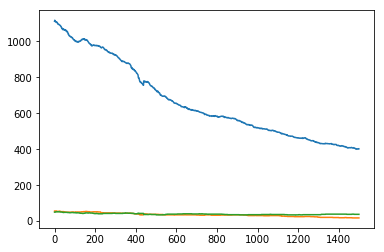

In [7]:
plt.plot(np.array(train_errors))
plt.plot(np.array(validation_errors))
plt.plot(np.array(test_errors))
plt.show()

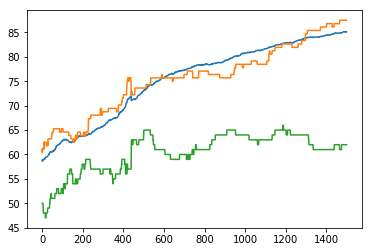

In [8]:
plt.plot(100*(Ntrain-np.array(train_errors))/Ntrain)
plt.plot(100*(Nvalidation-np.array(validation_errors))/Nvalidation)
plt.plot(100*(Ntest-np.array(test_errors))/Ntest)

plt.show()